# Example 2: Forecasting API


In this example, you are working for the logistics arm of a large retail chain. To maximize the flow of goods, the company would like to help regional logistics planners get ahead of particularly busy periods and to avoid product sell-outs. After discussions with stakeholders and subject matter experts across the business, it is agreed that the ability for planners to dynamically request and explore forecasts for particular warehouse items through a web-hosted dashboard is optimal. This allows the planners to understand likely future demand profiles before they make orders.

The data scientists come good again and find that the data has very predictable behavior at the level of any individual store. They decide to use the Facebook Prophet library for their modeling to help speed up the process of training many different models.

This example will use the open Rossman stores dataset from Kaggle, which can be found [here](https://www.kaggle.com/pratyushakar/rossmann-store-sales)

## Import data

First, we read in the data from the folder where we have extracted the data. We will perform all the following steps on the `train` dataset provided in the download but treat this as an entire dataset that we wish to split into training and test sets anyway

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
fp = os.path.join('..', 'data', 'rossman', 'train.csv')
df = pd.read_csv(fp)
print(df.info())
df.head()

/tmp/ipykernel_14572/1676415366.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## Explore data

In [17]:
# visualization
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import warnings

%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15, 10)})
warnings.filterwarnings("ignore")

In [7]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### Explore the `Store` column

In [8]:
df.Store.value_counts()

1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: Store, Length: 1115, dtype: int64

In [10]:
df.Store.value_counts().value_counts()

942    934
758    180
941      1
Name: Store, dtype: int64

There are 1115 stores in the dataset.
* 934 of the stores have 942 rows, and therefore 942 days of data.
* 180 of the stores have 758 rows, and therefore 758 days of data.
* 1 store has 941 rows, and therefore 941 days of data.

### Explore the `Date` column

In [11]:
df.Date.value_counts()

2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: Date, Length: 942, dtype: int64

In [12]:
df.Date.value_counts().value_counts()

1115    757
935     184
1114      1
Name: Date, dtype: int64

There are 942 days in the dataset.
* 757 of the dates 1115 rows. therefore all stores had sales on these days.
* 184 of the dates have 935 rows. therefore 180 stores were closed on these days/data is not available.
* 1 date has 1114 rows. therefore 1 store was closed on this day/data is not available for this store on this day.

### Explore the `Sales` column

In [19]:
df.Sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

Text(0, 0.5, 'Frequency')

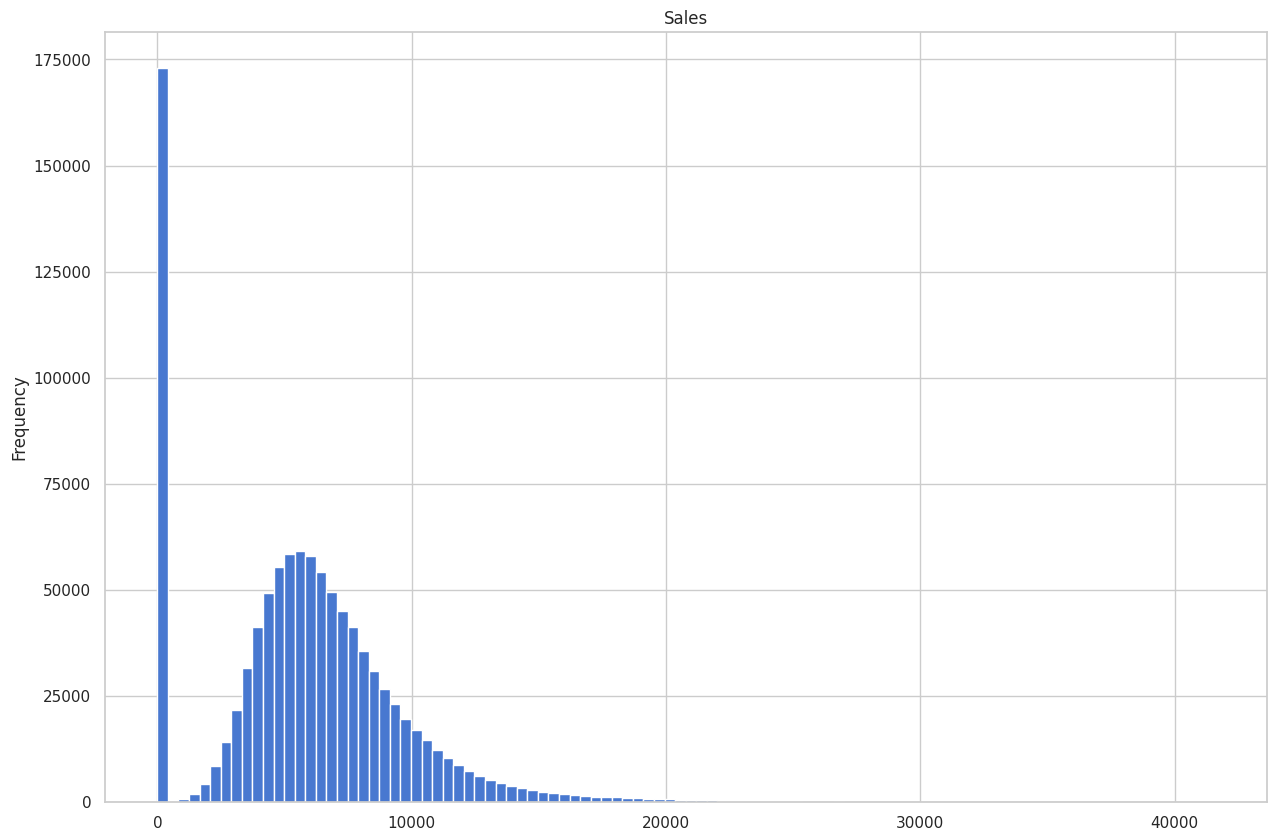

In [18]:
df.Sales.hist(bins=100)
plt.title('Sales')
plt.ylabel('Frequency')

The sales data is right skewed, with a long tail. This is expected as there will be a few days where sales are very high, and most days where sales are low. This is also expected as there will be a few stores where sales are very high, and most stores where sales are low.

According to the histogram, there are a few days when sales are 0. This is likely due to the store being closed on that day. We will explore this further in the next section.

### Explore the `Customers` column

In [20]:
df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

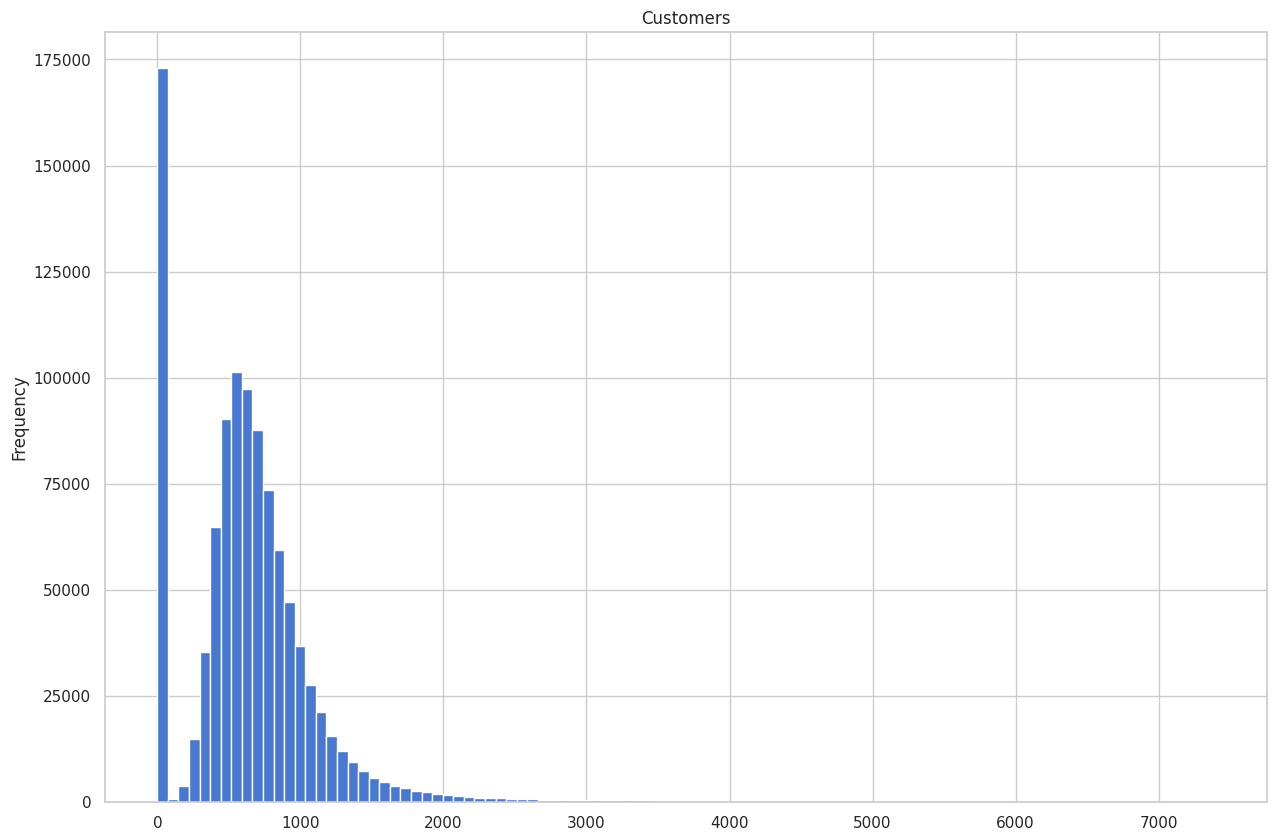

In [21]:
df.Customers.hist(bins=100)
plt.title('Customers')
plt.ylabel('Frequency')
plt.show()

The customers data is right skewed, with a long tail. This is expected as there will be a few days where customers are very high, and most days where customers are low. This is also expected as there will be a few stores where customers are very high, and most stores where customers are low.


### Explore `Sales` and `Customers` columns

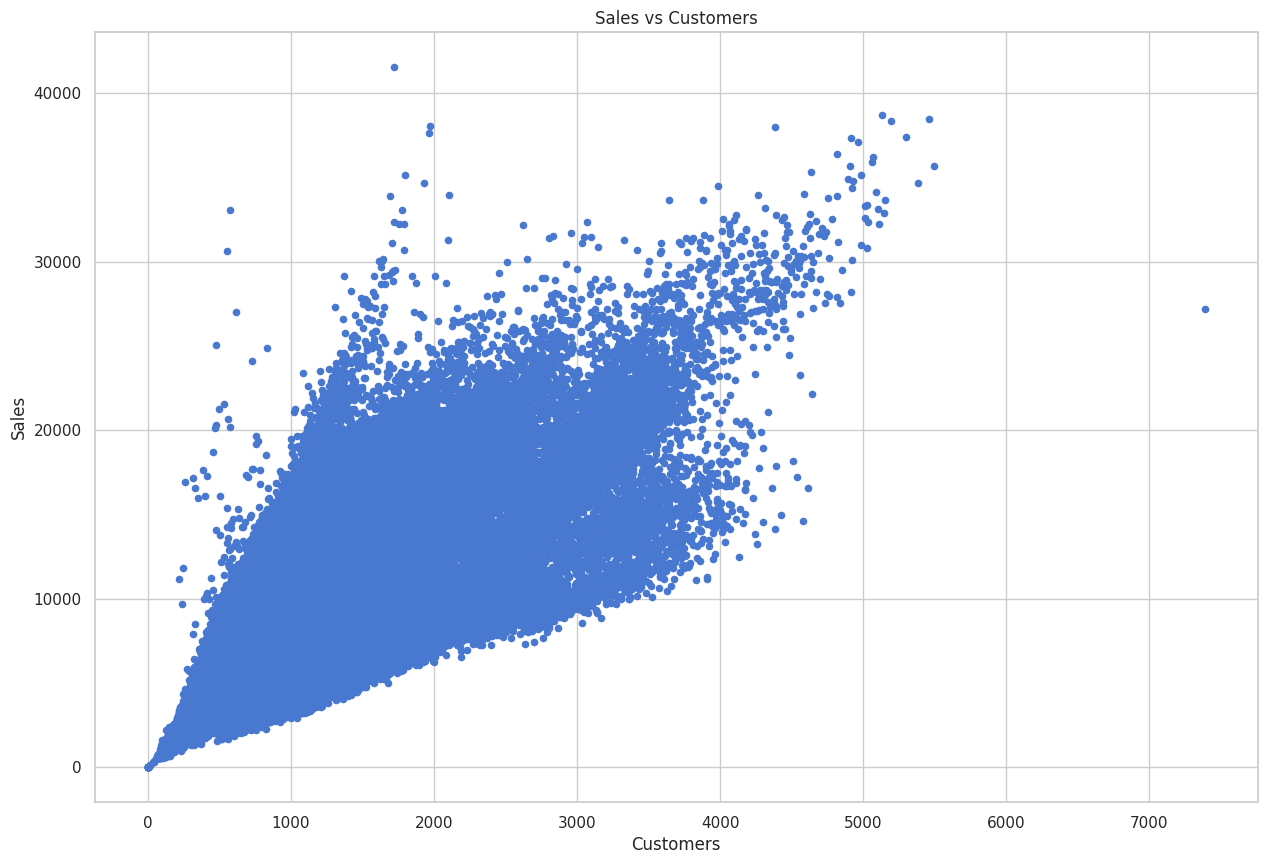

In [22]:
df.plot.scatter(x='Customers', y='Sales')
plt.title('Sales vs Customers')
plt.show()

### Explore `Open` column

In [25]:
df.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

<AxesSubplot:ylabel='Open'>

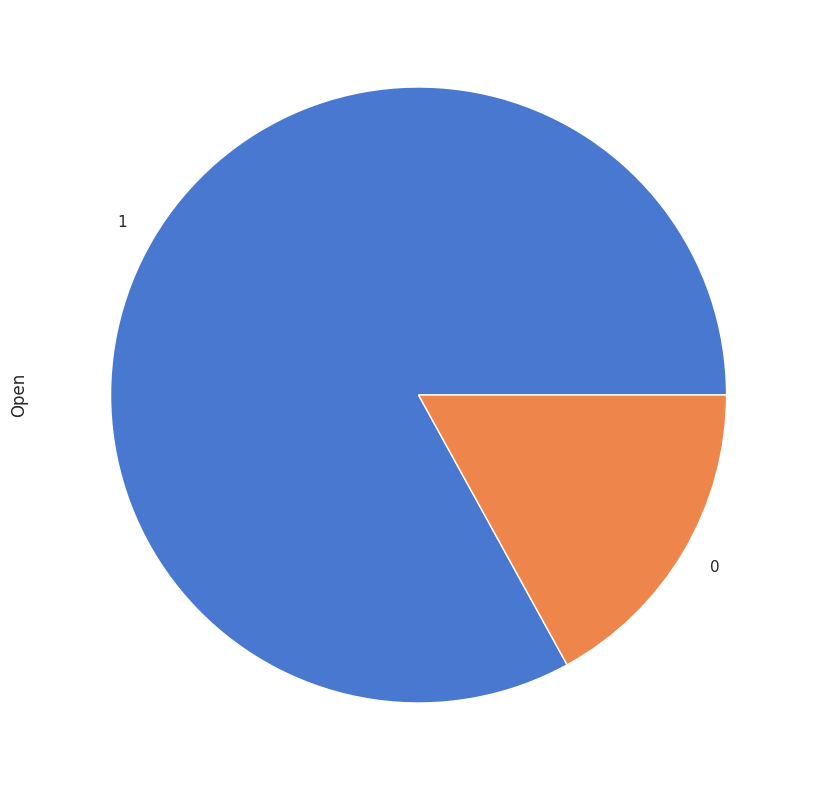

In [26]:
df.Open.value_counts().plot.pie()

compare `Sales` and `Customers` with `Open`

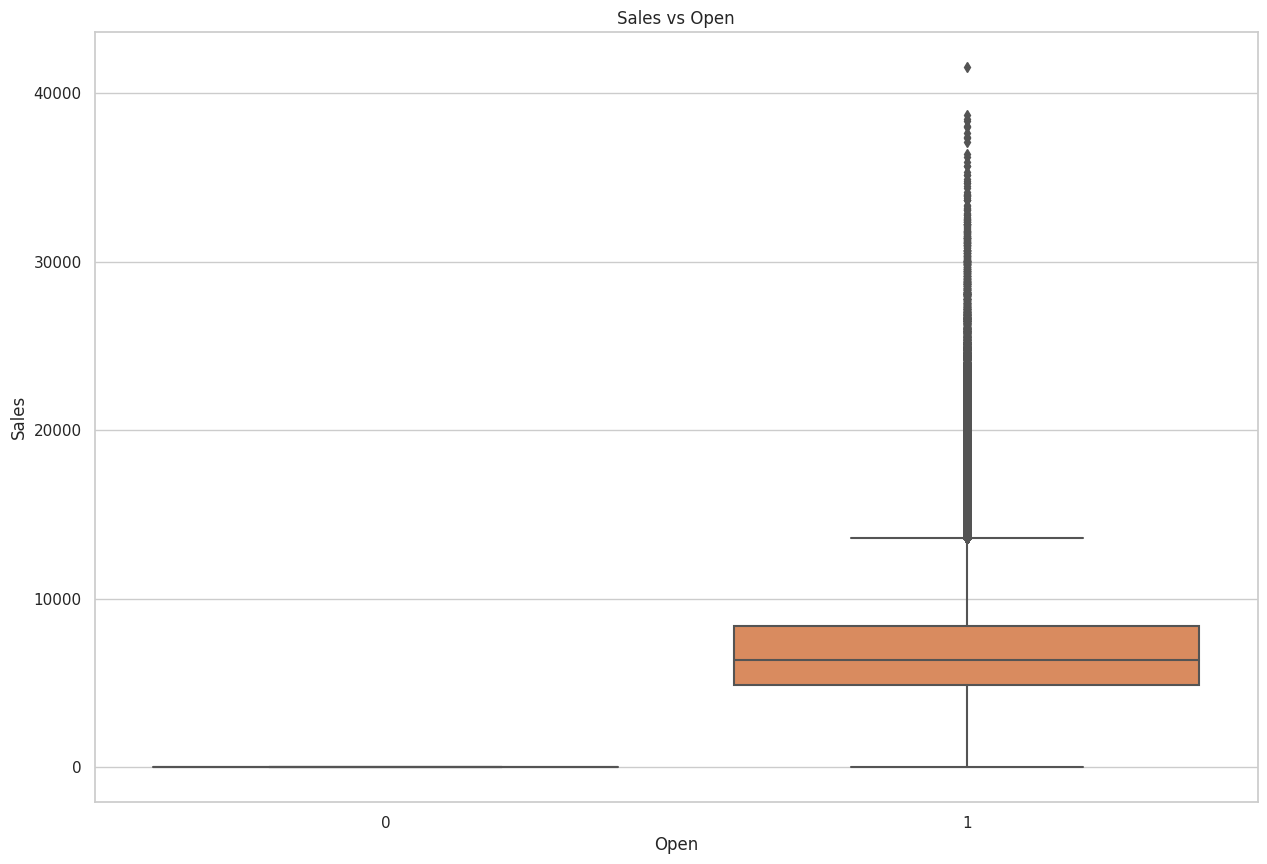

In [29]:
sns.boxplot(x='Open', y='Sales', data=df)
plt.title('Sales vs Open')
plt.show()